In [1]:
import os, sys
os.chdir('../')
from methods import *
from datasets import toyData
from utils import dbscan_results, kmeans_results

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [51]:
dataset_name = 'toy'

In [52]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    dataset_name,
    128,
    'y',
    'a',
    0,
    0,
    'fairness',
    outlier = 1,
    load_representations = True,
    start_model_path = '/mnt/cloud/yzeng58/privateDemographics/models/toy/erm_num_epoch_100_batch_size_128_lr_0.01_subsample_0_weight_decay_0.0001_outlier_0_model_logreg_best.model',
    seed = 123,
    method = 'grass',
    device = torch.device('cpu'),
    lr = 1e-3,
    weight_decay = 1e-5,
    model = '',
)


Loading the toy dataset with outlier = 1!


In [53]:
grad, true_domain, idx_class, true_group, idx_mode = collect_gradient(
    model,
    m,
    loader,
    device, 
    optim,
    num_domain,
    num_group,
    'fairness',
    lr_scheduler,
    dataset_name,
    num_class,
    outlier = 1
)

Loaded all the gradient information into folder /mnt/cloud/yzeng58/privateDemographics/results/toy/outliers...


In [54]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    dataset_name,
    loader,
    device,
    m,
    num_domain,
    outlier = 1,
)

Loaded all the input information into folder /mnt/cloud/yzeng58/privateDemographics/results/toy/outliers...


In [55]:
def map_num(ar):
    results, counts = np.unique(ar, return_counts = True)
    idx = sorted(range(len(results)), key = lambda i: counts[i], reverse = True)
    new_ar = np.zeros(ar.shape)
    for i,j in enumerate(idx):
        new_ar[ar==results[j]] = i
    # print(np.unique(new_ar,return_counts=True))
    return new_ar.astype(int)

In [56]:
pred_domain_inputs, num_group = dbscan_results(    
    true_domain,
    num_class,
    idx_class,
    true_group,
    grad, 
    process_grad=0, 
    use_val_group=0,
    eps_iter = [0.004],
    min_samples_iter = [5]
)

-0.11286504510009288 -0.15932617
Number of group: 3
Best parameter:  {'eps': 0.004, 'min_samples': 5}
0.05863747821798683 -0.19423044
Number of group: 4
Best parameter:  {'eps': 0.004, 'min_samples': 5}
ARS:  0.5545170526405875
SS:  -0.057050195


In [57]:
pred_domain_inputs_kmeans, num_group = kmeans_results(    
    inputs, 
    true_domain,
    num_class,
    idx_class,
    true_group,
    use_val_group = 1,
    k_iter = [2],
)

Number of group: 2
Number of group: 4
ARS:  0.52657446834464
SS:  0.15672729054298906


In [10]:
def vis(mode,y,vis_representation,pred_domain=None,dataset='toy',n_components = 3):
    vis_group = None
    outlier = 1
    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
    )
    if outlier:
        folder_name = '%s/privateDemographics/results/%s/outliers' % (root_dir, dataset)
    else:
        folder_name = '%s/privateDemographics/results/%s' % (root_dir, dataset)

    grad_tsne = {}
    idx_class = np.load('%s/idx_class.npy' % folder_name)
    if vis_representation == 'inputs' and dataset == 'toy':
        file_name = '%s/%s.npy' % (folder_name, 'inputs')
        grad_tsne[dataset] = np.load(file_name)[idx_class == y]
    else:
        file_name = '%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, y)
        try:
            print('Loading the TSNE results...')
            grad_tsne[dataset] = np.load(file_name,allow_pickle=True)    
        except:
            print('Performing TSNE dimension reduction...')
            grad = np.load('%s/%s.npy' % (folder_name, vis_representation),allow_pickle=True)
            grad_tsne[dataset] = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=3).fit_transform(grad) 
            with open('%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, 0), 'wb') as f:
                print('Saving the TSNE results...')
                np.save(f, grad_tsne[dataset][idx_class == 0])
            with open('%s/%s_tsne_dim_%d_y_%d.npy' % (folder_name, vis_representation, n_components, 1), 'wb') as f:
                np.save(f, grad_tsne[dataset][idx_class == 1])
            grad_tsne[dataset] = grad_tsne[dataset][idx_class == y]

            
    try:
        with open('%s/pred_dict_outlier_%d.json' % (folder_name, outlier), 'r') as f:
            pred_dict = json.load(f)
    except:
        with open('%s/pred_dict_outlier_%d_val_%d.json' % (folder_name, outlier, 1), 'r') as f:
            pred_dict = json.load(f)
    if vis_representation == 'inputs':
        if not pred_domain is None:
            pred_group = map_num(pred_domain[idx_class == y])
    else:
        pred_group = map_num(np.array(pred_dict['train'] + pred_dict['val'])[idx_class == y])
    true_domain = map_num(np.load('%s/true_domain.npy' % (folder_name))[idx_class == y])
    
        
    if mode == 'true':
        vis_group = true_domain
    elif mode == 'pred':
        vis_group = pred_group
    elif mode == 'acc':
        vis_group = pred_group == true_domain

    return grad_tsne[dataset], map_num(vis_group)

Loading the TSNE results...
Loading the TSNE results...


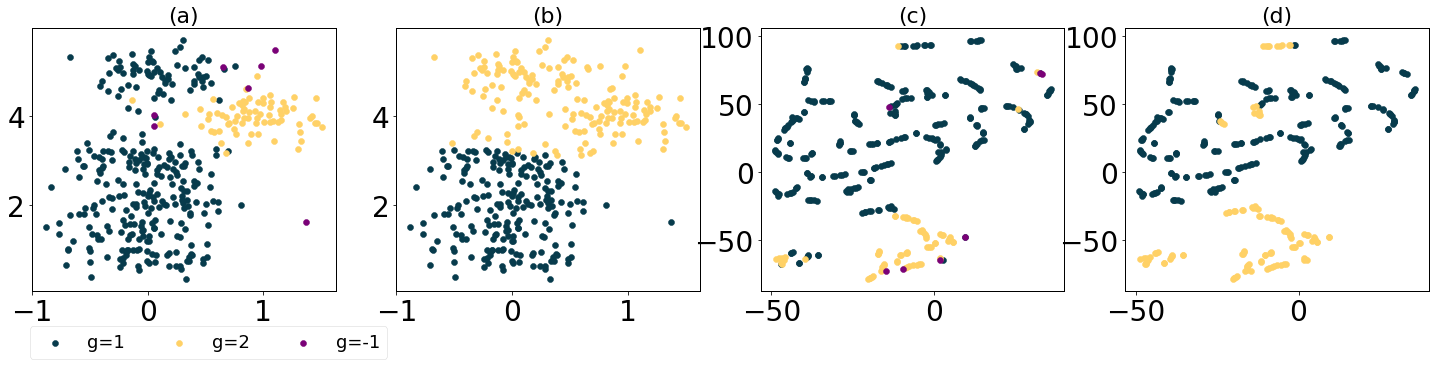

In [35]:
width = 20
height = 5


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166', '#7A0177','#06D6A0','#118AB2', '#DD3497'])

fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
fig.subplots_adjust(left=.02, bottom=.2, right=0.99, top=0.93, wspace=0.2, hspace=0.05) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure

titles = ['(a)', '(b)', '(c)', '(d)']
groups = ['g=1', 'g=2', 'g=-1']

for i, rep in enumerate(['inputs', 'grad']):
    for j, mode in enumerate(['true', 'pred']):
        if rep =='inputs':
            results, vis_group = vis(mode,0,rep,pred_domain_inputs_kmeans,'toy',2)
        else:
            results, vis_group = vis(mode,0,rep,None,'toy',2)

        c = colors[vis_group]
        # print(np.unique(c, return_counts=True))
        for idx in range(len(np.unique(c))):
            ax[i*2+j].scatter(        
                results[:, 0][vis_group == idx],  # <-- Put your data instead
                results[:, 1][vis_group == idx],  # <-- Put your data instead
                c = colors[idx],
                label = groups[idx],
            )
        ax[i*2+j].set_title(titles[i*2+j], size = 22)
ax[0].legend(bbox_to_anchor=(1.2,-.1), fontsize = 18, ncol=3)
plt.savefig('%s/privateDemographics/figures/grad_vis_synthetic.pdf' % root_dir)



Loading the TSNE results...


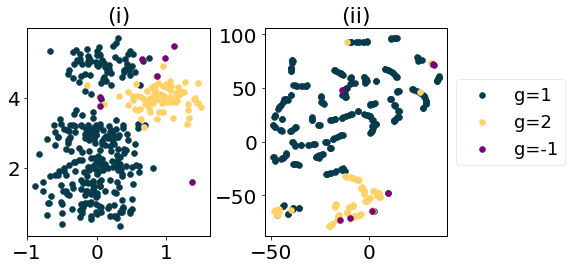

In [50]:
width = 8
height = 3.6


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166', '#7A0177','#06D6A0','#118AB2', '#DD3497'])

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
fig.subplots_adjust(left=.05, bottom=.1, right=0.78, top=0.9, wspace=0.3, hspace=0.05) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure

titles = ['(i)', '(ii)']
groups = ['g=1', 'g=2', 'g=-1']

for i, rep in enumerate(['inputs', 'grad']):
    for j, mode in enumerate(['true']):
        if rep =='inputs':
            results, vis_group = vis(mode,0,rep,pred_domain_inputs_kmeans,'toy',2)
        else:
            results, vis_group = vis(mode,0,rep,None,'toy',2)

        c = colors[vis_group]
        # print(np.unique(c, return_counts=True))
        for idx in range(len(np.unique(c))):
            ax[i+j].scatter(        
                results[:, 0][vis_group == idx],  # <-- Put your data instead
                results[:, 1][vis_group == idx],  # <-- Put your data instead
                c = colors[idx],
                label = groups[idx],
            )
        ax[i+j].set_title(titles[i+j], size = 22)
ax[1].legend(bbox_to_anchor=(1,0.8), fontsize = 18)
plt.savefig('%s/privateDemographics/figures/grad_vis_synthetic.pdf' % root_dir)



Loading the TSNE results...


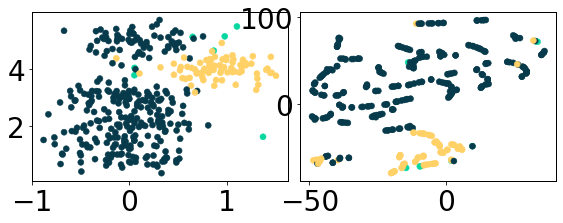

In [29]:
width = 8
height = 2.6


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
fig.subplots_adjust(left=.08, bottom=.05, right=0.99, top=0.95, wspace=0.05, hspace=0.05) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure

for i, rep in enumerate(['inputs', 'grad']):
    for j, mode in enumerate(['true']):
        results, vis_group = vis(mode,0,rep,n_components=2)
        if mode == 'acc':
            c = np.array(['red', 'green'])[vis_group]
        else:
            c = colors[vis_group]
        ax[i].scatter(        
            results[:, 0],  # <-- Put your data instead
            results[:, 1],  # <-- Put your data instead
            c = c
        )
plt.savefig('%s/privateDemographics/figures/grad_vis_waterbirds.pdf' % root_dir)

Loading the TSNE results...
Loading the TSNE results...
Loading the TSNE results...


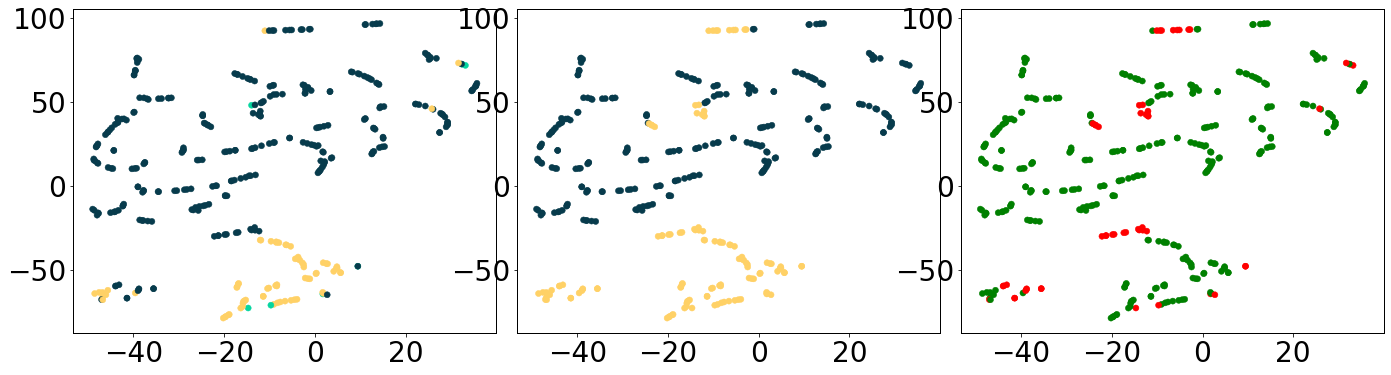

In [34]:
width = 20
height = 5


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
fig.subplots_adjust(left=.08, bottom=.05, right=0.99, top=0.95, wspace=0.05, hspace=0.05) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure

for i, rep in enumerate(['grad']):
    for j, mode in enumerate(['true', 'pred', 'acc']):
        results, vis_group = vis(mode,0,rep,pred_domain_inputs_kmeans,'toy',2)
        if mode == 'acc':
            c = np.array(['red', 'green'])[map_num(vis_group)]
        else:
            c = colors[vis_group]
        ax[j].scatter(        
            results[:, 0],  # <-- Put your data instead
            results[:, 1],  # <-- Put your data instead
            c = c
        )


Loading the TSNE results...
Loading the TSNE results...
Loading the TSNE results...


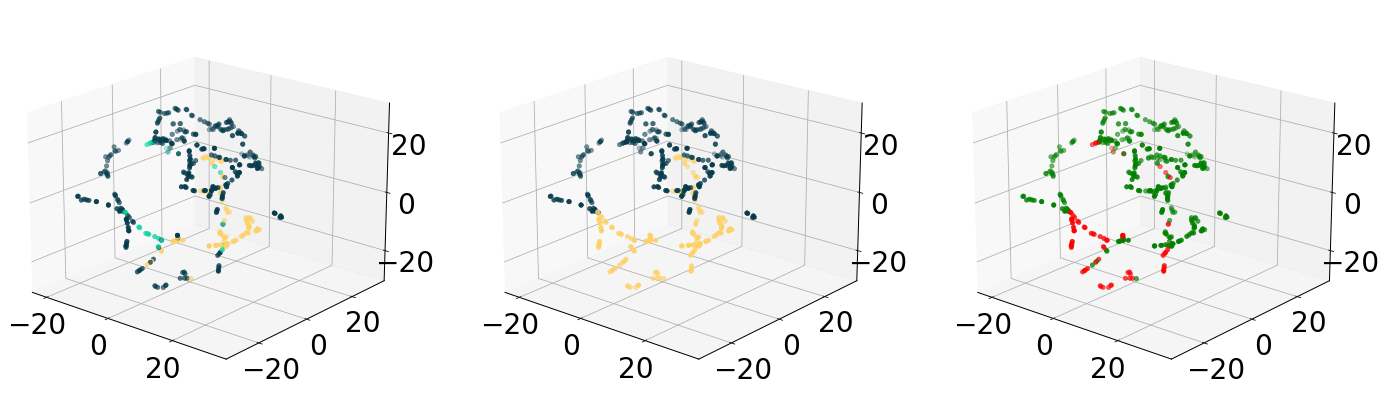

In [96]:
width = 20
height = 5


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(width, height) #exact size of the figure
fig.subplots_adjust(left=.02, bottom=.0, right=0.95, top=1.1) #margin of the figure

for j, mode in enumerate(['true', 'pred', 'acc']):
    ax = fig.add_subplot(1, 3, j+1, projection='3d')
    results, vis_group = vis(mode,1,'grad')
    if mode == 'acc':
        c = np.array(['red', 'green'])[vis_group]
    else:
        c = colors[vis_group]
    ax.scatter(        
        results[:, 0],  # <-- Put your data instead
        results[:, 1],  # <-- Put your data instead
        results[:, 2],
        c = c
    )
    ax.view_init(20,-50)


Loading the TSNE results...
Loading the TSNE results...
Loading the TSNE results...


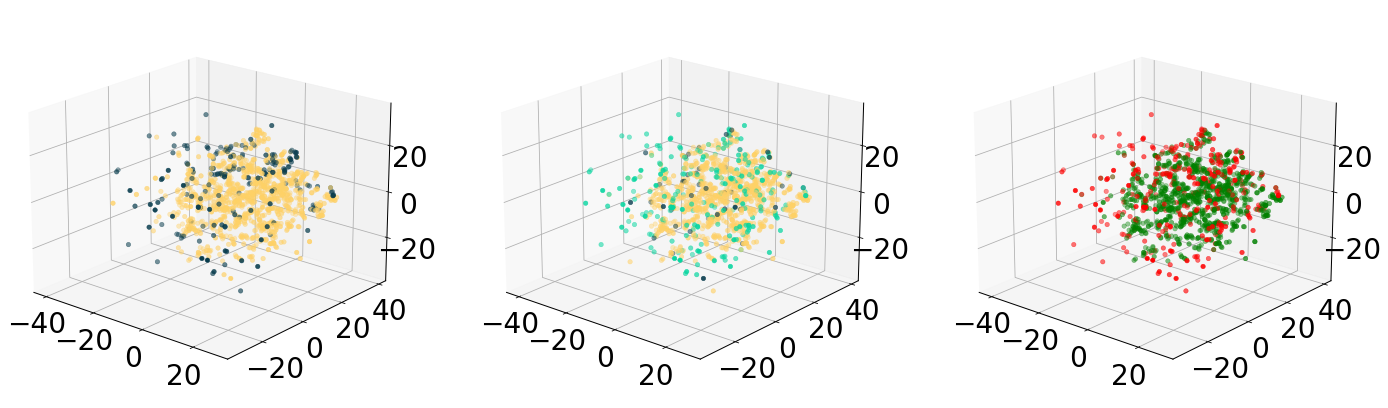

In [100]:
width = 20
height = 5


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(width, height) #exact size of the figure
fig.subplots_adjust(left=.02, bottom=.0, right=0.95, top=1.1) #margin of the figure

for j, mode in enumerate(['true', 'pred', 'acc']):
    ax = fig.add_subplot(1, 3, j+1, projection='3d')
    results, vis_group = vis(mode,1,'inputs','waterbirds')
    if mode == 'acc':
        c = np.array(['red', 'green'])[vis_group]
    else:
        c = colors[vis_group]
    ax.scatter(        
        results[:, 0],  # <-- Put your data instead
        results[:, 1],  # <-- Put your data instead
        results[:, 2],
        c = c
    )
    ax.view_init(20,-50)


Loading the TSNE results...
Loading the TSNE results...
Loading the TSNE results...


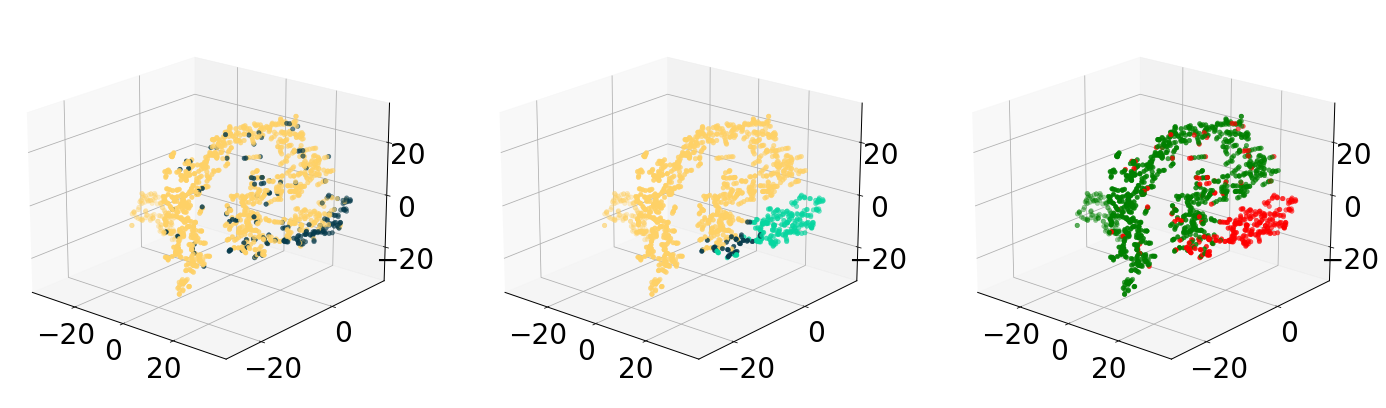

In [98]:
width = 20
height = 5


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(width, height) #exact size of the figure
fig.subplots_adjust(left=.02, bottom=.0, right=0.95, top=1.1) #margin of the figure

for j, mode in enumerate(['true', 'pred', 'acc']):
    ax = fig.add_subplot(1, 3, j+1, projection='3d')
    results, vis_group = vis(mode,1,'grad','waterbirds')
    if mode == 'acc':
        c = np.array(['red', 'green'])[vis_group]
    else:
        c = colors[vis_group]
    ax.scatter(        
        results[:, 0],  # <-- Put your data instead
        results[:, 1],  # <-- Put your data instead
        results[:, 2],
        c = c
    )
    ax.view_init(20,-50)


Loading the TSNE results...
Loading the TSNE results...


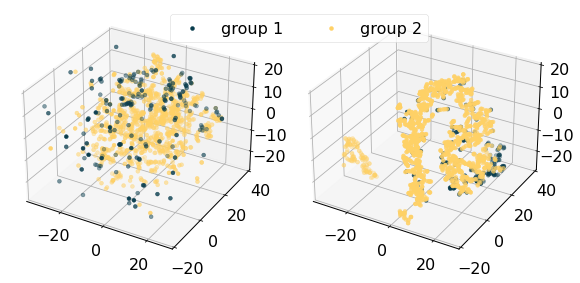

In [42]:
width = 8
height = 3.6


# plt.rc('font', family='serif', serif='times new roman')
plt.rc('font', family='sans-serif')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(width, height) #exact size of the figure
fig.subplots_adjust(left=.0, bottom=.0, right=0.95, top=1, wspace = 0.1) #margin of the figure

for j, rep in enumerate(['inputs', 'grad']):
    mode = 'true'
    ax = fig.add_subplot(1, 2, j+1, projection='3d')
    results, vis_group = vis(mode,1,rep,None,'waterbirds')
    if mode == 'acc':
        color = np.array(['red', 'green'])[vis_group]
    else:
        color = colors[vis_group]
    cs = np.unique(color)
    for i, c in enumerate(cs):
        idx = color == c
        ax.scatter(        
            results[:, 0][idx],  # <-- Put your data instead
            results[:, 1][idx],  # <-- Put your data instead
            results[:, 2][idx],
            c = c, 
            label = 'group %d' % (i+1),
            s = 15
        )
    # ax.view_init(20,-50)
    ax.xaxis.labelpad = -1
    ax.yaxis.labelpad = 10
    ax.set_ylim(-20, 40)
    ax.set_xlim(-35, 30)
    ax.set_zlim(-28, 20)
plt.legend(ncol = 2, bbox_to_anchor = (0.55,1), fontsize = 16)
plt.savefig('%s/privateDemographics/figures/grad_vis_waterbirds.pdf' % root_dir)

Loading the TSNE results...
Loading the TSNE results...
Loading the TSNE results...


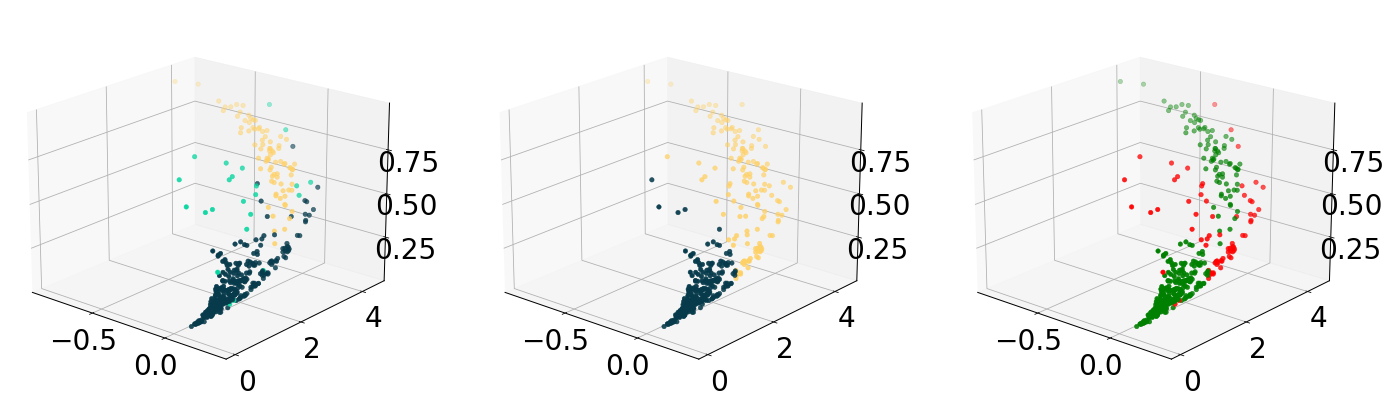

In [250]:
width = 20
height = 5


# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 2
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(width, height) #exact size of the figure
fig.subplots_adjust(left=.02, bottom=.0, right=0.95, top=1.1) #margin of the figure

for j, mode in enumerate(['true', 'pred', 'acc']):
    ax = fig.add_subplot(1, 3, j+1, projection='3d')
    results, vis_group = vis(mode,1,'grad','toy')
    results = grad.T[[0,1,4]].T[idx_class == 1]
    if mode == 'acc':
        c = np.array(['red', 'green'])[vis_group]
    else:
        c = colors[vis_group]
    ax.scatter(        
        results[:, 0],  # <-- Put your data instead
        results[:, 1],  # <-- Put your data instead
        results[:, 2],
        c = c
    )
    ax.view_init(20,-50)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: times new roman


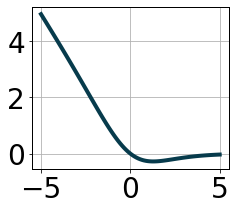

In [7]:
width = 3
height = 2.5


plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
mpl.rcParams['lines.linewidth'] = 4
colors = np.array(['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497'])

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
fig.subplots_adjust(left=.08, bottom=.05, right=0.99, top=0.95, wspace=0.05, hspace=0.05) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure

x = np.linspace(-5,5,100)
def g(x):
    return (1/(1+np.exp(-x))-1)*x

ax.plot(x, g(x), c=colors[0])
ax.grid()
ax.set_yticks([0,2,4])
None

In [17]:
import matplotlib
import os
fm = matplotlib.font_manager.json_load(os.path.expanduser("/home/yzeng58/.cache/matplotlib/fontlist-v330.json"))
fm.findfont("serif", rebuild_if_missing=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: times new roman


'/home/yzeng58/anaconda3/envs/ibm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [15]:
os.path.isfile("/home/yzeng58/.cache/matplotlib/fontlist-v330.json")

True

In [18]:
fm.findfont("serif", fontext="afm", rebuild_if_missing=False)

findfont: Font family ['serif'] not found. Falling back to Helvetica.
findfont: Generic family 'serif' not found because none of the following families were found: times new roman


'/home/yzeng58/anaconda3/envs/ibm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/afm/phvr8a.afm'

In [11]:
os.listdir("/home/yzeng58/.cache/matplotlib")

['fontlist-v330.json', 'tex.cache']

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

import matplotlib.font_manager
import os
fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v300.json"))

fm.findfont("serif", rebuild_if_missing=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/yzeng58/.cache/matplotlib/fontlist-v300.json'

In [8]:
groups = np.array([
    [15.79,-3.29], 
    [16.52,-2.98],
    [15.96,-2.41],
    [17.38, -3.37],
    [17.55, -2.5],
    [18.11,-3.07],
    [20.48,-3.19],
    [20.87,-2.57],
    [20.15,-2.49],
    [19.07,-1.75],
    [19.83, -1.54],
    [19.43,-1.08],
    [15.96,-.99]
])

In [15]:
groups = np.array([
    [26.94,-1.55],
    [27.69,-1.39],
    [27.27,-0.86],
    [23.88,-0.76],
    [26.19,-2.36],
    [25.95,-2.32],
    [26.01,-2.52],
    [25.49,-2.33],
    [25.63,-2.53],
    [25.38,-2.62],
    [25.12,-2.36],
    [25.11,-2.68],
    [25.29,-2.38]
])

In [16]:
len(groups)

13

In [17]:
groups.mean(axis=0)

array([25.84230769, -2.05076923])

In [58]:
# This chunk is just to quickly load all the necessary variables...
# No need to understand this chunk!

(
    m,
    loader,
    optim,
    model,
    num_domain,
    num_group,
    lr_scheduler,
    device,
    n,
    num_feature,
    num_class,
) = exp_init(
    'civilcomments',
    32,
    'y',
    'a',
    0,
    0,
    'fairness',
    outlier = 0,
    load_representations = True,
    start_model_path = '%s/privateDemographics/models/civilcomments/sgd_m_1_num_epoch_10_batch_size_32_lr_1e-05_optimizer_adam_subsample_0_weight_decay_0.01_best.model'  % root_dir,
    seed = 123,
    method = 'grass',
    device = torch.device('cpu'),
    lr = 1e-3,
    weight_decay = 1e-5,
    model = '',
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [59]:
inputs, true_domain, idx_class, true_group, idx_mode, losses = collect_representations(
    'civilcomments',
    loader,
    device,
    m,
    num_domain,
    outlier = 1,
)

Loading Representation for val set: 100%|██████████| 759/759 [38:01<00:00,  3.01s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/cloud/yzeng58/privateDemographics/results/civilcomments/outliers/inputs.npy'